## Data:

Generally, when dealing with image, text, audio or video data, use standard python packages that load data into a numpy array.
Then convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, I use a package called ``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., ``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

In this notebook, CIFAR10 dataset is used. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10

## Training an Image Classifier

Steps followed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [1]:
#Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

The output of torchvision datasets are PILImage images of range [0, 1]. Next, transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Display a few training images.

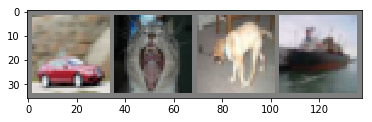

       car        cat        dog       ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. Define a Loss function and optimizer

Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

Loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(2):  #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        #Zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.226
[1,  4000] loss: 1.932
[1,  6000] loss: 1.733
[1,  8000] loss: 1.607
[1, 10000] loss: 1.534
[1, 12000] loss: 1.492
[2,  2000] loss: 1.424
[2,  4000] loss: 1.376
[2,  6000] loss: 1.358
[2,  8000] loss: 1.351
[2, 10000] loss: 1.326
[2, 12000] loss: 1.314
Finished Training


Save trained model:

In [7]:
PATH = './image_classification.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>` for more details on saving PyTorch models.

### 5. Test the network on the test data

Till now, trained the network for 2 passes over the training dataset. But it is essential to check if the network has learnt anything at all.

In order to check this, predict the class label that the neural network outputs, and check it against the ground-truth. If the prediction is correct, add the sample to the list of correct predictions.

First step, display an image from the test set to get familiar.

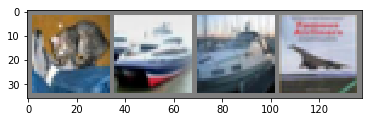

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, load back in the saved model (note: saving and re-loading the model wasn't necessary here)

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Determine the output of Neural Network for the above examples.

In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. Next, get the index of the highest energy:

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


The results seem pretty good.

Next, look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


The results are much better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Determine the classes that performed well, and the classes that did not perform well:

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 46 %
Accuracy of  bird : 44 %
Accuracy of   cat : 30 %
Accuracy of  deer : 45 %
Accuracy of   dog : 48 %
Accuracy of  frog : 62 %
Accuracy of horse : 48 %
Accuracy of  ship : 63 %
Accuracy of truck : 70 %


## Training on GPU

The approach to transfer a Neural Network onto the GPU is similar to the transfer of a Tensor onto the GPU.

If the device has CUDA available, define the device as the first visible cuda device:

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Assuming that the device is a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember to send the inputs and targets at every step to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Massive speedup (compared to CPU) is noticed only when the network is large. In the current case, the network is quite small.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

In [15]:
inputs, labels = data[0].to(device), data[1].to(device)

In [16]:
from PIL import Image
from torch.autograd import Variable

imsize = 32
loader = transforms.Compose([transforms.Resize((imsize,imsize)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) #this is for VGG, may not be needed for ResNet
    return image

image = image_loader("./dog.jpg")
confidences = net(image)
_, predicted = torch.max(confidences, 1)
print(classes[predicted])

dog


## Next steps:

-  `Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`
-  `Train a face generator using Generative Adversarial Networks`
-  `Train a word-level language model using Recurrent LSTM networks`